In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score

import time

# Downloading the Dataset

In [ ]:
download_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

import requests, zipfile, io

r = requests.get(download_url)

tar_bytes = io.BytesIO(r.content)

import tarfile

tf = tarfile.open(fileobj=tar_bytes)

tf.extractall()


Looking at the content of one of the text files.

In [ ]:
!cat aclImdb/test/pos/2301_8.txt

In the Realm of the Senses is a beautifully filmed, well-written, and splendidly acted film. It tells the haunting story of a woman who kills her husband after falling in love with another man. The ghost of her husband continues to haunt her lond after his murder. This film is really good, anyone interested should definitely check it out.

In [ ]:
import glob
train_pos = glob.glob("aclImdb/train/pos/*.txt")
train_neg = glob.glob('aclImdb/train/neg/*.txt')
test_pos = glob.glob('aclImdb/test/pos/*.txt')
test_neg = glob.glob('aclImdb/test/neg/*.txt')
files = [train_pos,train_neg,test_pos,test_neg]

In [ ]:
import string
punct = string.punctuation
punct
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Here, I had appended all the files into one list to extract all the unique words out of both the train and test datasets.

In [ ]:
g = []
for file in files:
  for r in file:
    with open(r,'r') as myfile:
      data = myfile.readlines()
      g.append(data)

I had removed all the punctuations and the stopwords from these reviews. Because stopwords such as 'the', 'a', 'an' dosen't really tell much about the data. And including these words would result in overfitting our model. 

For instance consider the word 'fantasic', it means that movie was great, and the model can predict it as positive review straight away.
These are the words that matter the most in training an algorithm and removing the stopwords can increase the accuracy of our model.

In [ ]:
result_list=[]
for i in g:
  word_tokens = word_tokenize(i[0])
  filtered_sentence = []
  for w in word_tokens: 
      if w not in stop_words:
          if w not in punct:
              for n in punct:
                  w = str(w).replace(n,'')
              if re.match(r'\w+',w):    
                  filtered_sentence.append(w.lower())
                    
  for x in filtered_sentence:
      if x not in result_list:
          result_list.append(x)
  unique_words = result_list       

In [ ]:
len(unique_words)

139142

# Vectorizing the Data

Defining the class Vocabulary to convert the words into integers.

In [ ]:
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]


In [ ]:
voc = Vocabulary('unique')

In [ ]:
corpus = unique_words
for w in corpus:
  voc.add_word(w)


In [ ]:
tokens=[]
for w in corpus:
  tokens.append(voc.to_index(w))

Creating a dictionary for all the unique words and the integers that were assigned to those words as a key:value pair.

In [ ]:
dic1 = {corpus[i]:tokens[i] for i in range(len(corpus))}

I have replaced the words with integers and converted them into tensors.

In [ ]:
g1=[]
for i in g:
  word_tokens = word_tokenize(i[0])
  filtered_sentence = []
  for w in word_tokens: 
      if w not in stop_words:
          if w not in punct:
              for n in punct:
                  w = str(w).replace(n,'')
              if re.match(r'\w+',w):    
                  filtered_sentence.append(dic1[w.lower()])
                    
  g1.append(torch.tensor(filtered_sentence)) 

In [ ]:
len(g1)

50000

In [ ]:
g1[1]

tensor([111, 228, 229, 230, 106, 231, 232, 233, 234, 235, 236, 175,  26, 237,
        238, 239, 240, 241, 215, 242, 106, 192, 121, 243,  26, 244, 245, 246,
         22, 247, 248, 249,  38, 250, 251, 252,  22, 253, 254, 255, 256, 257,
        258,  52, 149, 259, 192, 239, 260, 261,  26, 262, 263, 264, 265, 266,
        267,  84, 268, 269, 270, 168, 271, 272,   3, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 172, 286,  43,  42,  46, 196,
        143, 287, 288, 289,  66, 290, 291, 222, 292, 293, 265, 180, 294, 295,
        296, 296, 297, 142, 298, 299, 279, 284, 115,   3, 300, 301, 302, 303,
        304, 305, 306, 197, 307, 308, 309, 310,   3, 273, 237, 311, 312, 313,
        314, 315, 316, 317, 237, 318, 319, 277,  26, 320, 321, 310,  42,  43,
        322, 254, 146, 299, 323, 287, 324])

# Preparing the data for training and testing

Since all the reviews were under one list, I had to split them into their designated categories before preparing the training and testing data.

And here I took only a subset of data because it was taking a couple of hours to run a model. The original size of the dataset was 25,000 rows for the train and test set and I took 16,000 rows for  my analysis.



In [ ]:
train_pos1 = g1[0:8000]
train_neg1 = g1[12500:20500]
test_pos1 = g1[25000:33000]
test_neg1 = g1[37500:45500]
d = [train_pos1,train_neg1,test_pos1,test_neg1]

Appending the labels to the inputs.

In [ ]:
train_data = []
test_data = []
for j in range(len(train_pos1)):
    train_data.append([train_pos1[j],torch.tensor(1)])
for j in range(len(train_neg1)):
    train_data.append([train_neg1[j],torch.tensor(0)])
for j in range(len(test_pos1)):
    test_data.append([test_pos1[j],torch.tensor(1)])
for j in range(len(test_neg1)):
      test_data.append([test_neg1[j],torch.tensor(0)])

In [ ]:

len(test_data)


16000

In [ ]:
train_data[10]

[tensor([ 111,  730,  330, 1023, 1024, 1025, 1026, 1027,  781,  757, 1028,   42,
         1029,  428,  538, 1030,   41, 1031, 1032, 1033,  111, 1034, 1035,  112,
         1036, 1037,  260, 1038,  112,  113, 1039,  312,  330, 1040, 1041, 1042,
         1043, 1044, 1045,   41,   46, 1046, 1047, 1048,   22, 1049, 1050, 1051,
         1052, 1053,   40,  115,  330]), tensor(1)]

In [ ]:
train_data[100]
for inputs, labels in test_data:
  inputs = inputs
  lables = labels

In [ ]:
len(train_data[3][0])

145

In [ ]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tyuple (out, (h_t, c_t))
        rnn_output = input[0]

        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [ ]:
def pad_and_pack(batch):
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    longest = max(lengths)
    #We need to pad all the inputs up to 'longest', and combine into a batch ourselves
    if len(input_tensors[0].shape) == 1:
        x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    else:
        raise Exception('Current implementation only supports (T) shaped data')
    
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    
    y_batched = torch.as_tensor(labels, dtype=torch.long)
        
    return x_packed, y_batched

In [ ]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)

In [ ]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cuda", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# 3-Layer RNN

Here we are training the data with batch size of 10. Since our reviews dataset has a different length of words for each review we need to pack them to provide a consistent dimentional length for each review to our training model. 

And the embedding layer dosen't support packed sequences of data. To fix this we use a function called EmbeddingPackable on the regular embedding layer to return a new packed sequence which is appropriate to our training model.

In [ ]:
B=10
trainloader = torch.utils.data.DataLoader(train_data,batch_size=B, shuffle=True,collate_fn=pad_and_pack)
testloader = torch.utils.data.DataLoader(test_data,batch_size=20, shuffle=False,collate_fn=pad_and_pack)

NameError: ignored

The alphabet size is the length of vocabulary. And we only have two classes i.e positive or negitive.

In [ ]:
D = 32
alphabet_size = 139142
hidden_nodes = 64
Classes = 2
rnn_3layer = nn.Sequential(
    EmbeddingPackable(nn.Embedding(alphabet_size,D)),
    nn.RNN(D, hidden_nodes, batch_first=True, num_layers=3),
    LastTimeStep(rnn_layers=3),
    nn.Linear(hidden_nodes, Classes)
)
rnn_3layer.to(device='cuda')

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(139142, 32)
  )
  (1): RNN(32, 64, num_layers=3, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
from sklearn.metrics import accuracy_score

In [ ]:
layer3_results = train_simple_network(rnn_3layer ,loss_func,train_loader=trainloader,val_loader=testloader,device='cuda',score_funcs={'Accuracy':accuracy_score},epochs=10,lr=0.001*B)

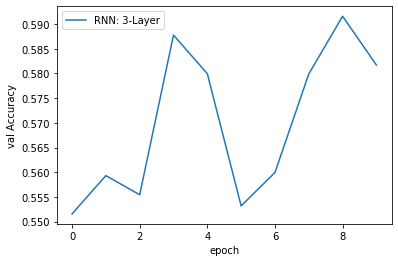

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=layer3_results, label='RNN: 3-Layer')

I think the drop in accuracy was because of providing too less data to train our model.

# RNN Bi-Directional

In Bi-Directional RNN the information traverse in both the directions, and we end up with twice the number or hidden nodes after we fit our algorithm. 

In [ ]:
rnn_bidirectional = nn.Sequential(
    EmbeddingPackable(nn.Embedding(alphabet_size, D)),
    nn.RNN(D, hidden_nodes, batch_first=True, num_layers=3,bidirectional=True),
    LastTimeStep(rnn_layers=3, bidirectional=True),
    nn.Linear(hidden_nodes*2, Classes)
)
rnn_bidirectional.to(device='cuda')

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(139142, 32)
  )
  (1): RNN(32, 64, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
bidirectional_results = train_simple_network(rnn_bidirectional ,loss_func,train_loader=trainloader,val_loader=testloader,device='cuda',score_funcs={'Accuracy':accuracy_score},epochs=10)

KeyboardInterrupt: ignored

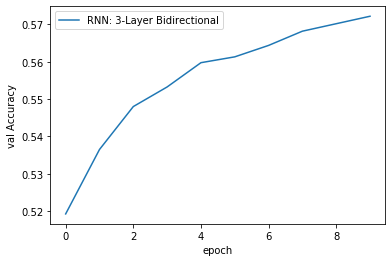

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=bidirectional_results, label='RNN: 3-Layer Bidirectional')

We dont have any drop in accuracy during the training of our algorithm compared to our first model. This might be due to the bi-directional nature of the algorithm which accumulates the information more evenly through the RNN, which makes the learining easier. 

Though the first model has higher accuracy that this model, it was more erratic in predicting our data than this model.

# LSTM

In [ ]:
lstm = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)),
  nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
  nn.Linear(hidden_nodes*2, Classes),
)

lstm.to(device='cuda')

lstm_results = train_simple_network(lstm, loss_func, trainloader, val_loader=testloader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10, lr=0.001*B)

KeyboardInterrupt: ignored

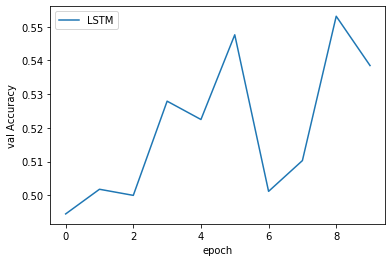

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_results, label='LSTM')

LSTM works better with large datasets. Since we are using a small dataset, the long term protion of the LSTM wouldn't be providing much of a benefit for us in trining the algorithm. Due to this only the short term part of the model is used in the training data. 

This might be the reason for the drop in accuracy after the 5th epoch.

# GRU

GRU (Gated Recurrent Unit) is a simplified version of LSTM which works better on shorter and simpler data.

In [ ]:
gru = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)),
  nn.GRU(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
  LastTimeStep(rnn_layers=3, bidirectional=True),
  nn.Linear(hidden_nodes*2, Classes),
)

gru.to(device='cuda')

gru_results = train_simple_network(gru, loss_func, trainloader, val_loader=testloader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cuda', epochs=10, lr=0.001*B)

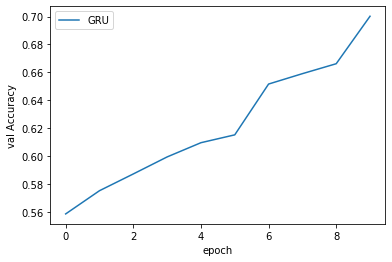

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results, label='GRU')

This model has the highest accuracy of all the models due to the simplification of its design to be able to train small datasets. This model reduces the parameters to be learned which makes it effective and efficient for shorter and simpler datasets.